# openpmd-scipp
Load openpmd datasets to `scipp` `DataArrays`.

## Description
### What is this good for?
`scipp` is an alternative to `xarray` and provides basically numpy arrays with axes description and units.
* Automatically load axes and units with openPMD data.
* Axes information  is automatically updated when slicing, indexing, or filtering your data.
* With `scipp`'s plotting library `plopp` it becomes an alternative to `openpmd-viewer`.
* Many numpy and some scipy functions including all the basic algebraic operations on arrays are supported by `scipp`. When using these, the units and coordinates are automatically taken care of. 

### Limitations
* `scipp` currently handles units with a library, that does not support non-integer exponents for units. This can become problematic in some calculations. 



## Installation
It can be easily installed with pip.
```bash
git clone ...
cd openpmd-scipp
pip install .
```

## Example use
Get example data sets from the `openPMD-example-datasets` repository.
```bash
git clone https://github.com/openPMD/openPMD-example-datasets.git
cd openPMD-example-datasets
tar -zxvf example-2d.tar.gz
tar -zxvf example-3d.tar.gz
```

### Opening series

In [1]:
import openpmd_scipp as pmdsc
import scipp as sc

path = 'openPMD-example-datasets/example-3d/hdf5/data%T.h5'
data_loader = pmdsc.DataLoader(path)

In [2]:
data_loader.iterations

<scipp.Dataset>
Dimensions: Sizes[t:5, ]
Coordinates:
* t                         float64              [s]  (t)  [3.28471e-14, 6.56942e-14, ..., 1.31388e-13, 1.64236e-13]
Data:
  iteration_id                int64  [dimensionless]  (t)  [100, 200, ..., 400, 500]

### Working with meshes (fields)
Let us plot electric field's x component at 65 fs. 


In [3]:
Ex = data_loader.get_field('E', 'x', time=65 * sc.Unit('fs'))
Ex

Series does not contain iteration at the exact time. Using closest iteration instead.


<scipp.DataArray>
Dimensions: Sizes[x:26, y:26, z:201, ]
Coordinates:
* t                         float64              [s]  ()  6.56942e-14
* x                         float64              [m]  (x)  [-9.6e-06, -8.8e-06, ..., 9.6e-06, 1.04e-05]
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (z)  [4.7e-06, 4.8e-06, ..., 2.46e-05, 2.47e-05]
Data:
                            float64            [V/m]  (x, y, z)  [-1.08652e+08, -1.9758e+08, ..., 0, 0]

You may have noticed, that the time requested does not have to match exactly any iteration. By default, if there is an iteration within 10 fs distance it will be used instead. This 10 fs tolerance can be adjusted by setting `time_tolerance`. The check can be also disabled by setting `time_tolerance=None`, with that the method will return the closest iteration regardless of the difference. So that this will also work:

In [4]:
data_loader.get_field('E', 'x', time=20 * sc.Unit('fs'), time_tolerance=20 * sc.Unit('fs'))

Series does not contain iteration at the exact time. Using closest iteration instead.


<scipp.DataArray>
Dimensions: Sizes[x:26, y:26, z:201, ]
Coordinates:
* t                         float64              [s]  ()  3.28471e-14
* x                         float64              [m]  (x)  [-9.6e-06, -8.8e-06, ..., 9.6e-06, 1.04e-05]
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (z)  [-5.2e-06, -5.1e-06, ..., 1.47e-05, 1.48e-05]
Data:
                            float64            [V/m]  (x, y, z)  [-1.08549e+07, -1.3967e+07, ..., 0, 0]

, but `data_loader.get_field('E', 'x', time=20 * sc.Unit('fs'))` not.

In [5]:
# It is also possible to use iteration number instead:
data_loader.get_field('E', 'x', iteration=200)

<scipp.DataArray>
Dimensions: Sizes[x:26, y:26, z:201, ]
Coordinates:
* t                         float64              [s]  ()  6.56942e-14
* x                         float64              [m]  (x)  [-9.6e-06, -8.8e-06, ..., 9.6e-06, 1.04e-05]
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (z)  [4.7e-06, 4.8e-06, ..., 2.46e-05, 2.47e-05]
Data:
                            float64            [V/m]  (x, y, z)  [-1.08652e+08, -1.9758e+08, ..., 0, 0]

In [6]:
# For scalar fields just omit the second argument:
data_loader.get_field('rho', iteration=200)

<scipp.DataArray>
Dimensions: Sizes[x:26, y:26, z:201, ]
Coordinates:
* t                         float64              [s]  ()  6.56942e-14
* x                         float64              [m]  (x)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (z)  [4.7e-06, 4.8e-06, ..., 2.46e-05, 2.47e-05]
Data:
                            float64           [mC/L]  (x, y, z)  [-7169.01, -7526.4, ..., 3.16049e-11, 1.22782e-11]

#### Plotting
W can't directly plot 3D data.
But we can for example select a slice. For that we can use a helper function `pmdsc.closest` to get the closets index, since `scipp` requires exact match. You can read more about indexing `scipp` arrays in `scipp`'s documentation.

In [7]:
slicing_idx = pmdsc.closest(Ex, 'x', 2 * sc.Unit('um'))
Ex_slice = Ex['x', slicing_idx]
Ex_slice

<scipp.DataArray>
Dimensions: Sizes[y:26, z:201, ]
Coordinates:
* t                         float64              [s]  ()  6.56942e-14
  x                         float64              [m]  ()  2.4e-06
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (z)  [4.7e-06, 4.8e-06, ..., 2.46e-05, 2.47e-05]
Data:
                            float64            [V/m]  (y, z)  [4.86614e+08, 6.67018e+08, ..., 0, 0]

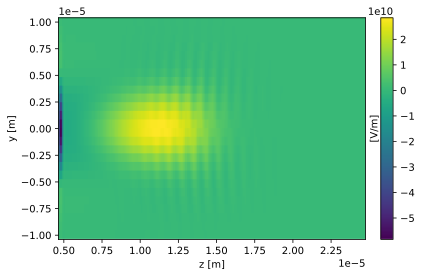

In [8]:
Ex_slice.plot()

In [9]:
# We can also plot line plots:
Ex_line = Ex_slice['z', pmdsc.closest(Ex_slice, 'z', 1.4e-5 * sc.Unit('m'))]
Ex_line

<scipp.DataArray>
Dimensions: Sizes[y:26, ]
Coordinates:
* t                         float64              [s]  ()  6.56942e-14
  x                         float64              [m]  ()  2.4e-06
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
  z                         float64              [m]  ()  1.4e-05
Data:
                            float64            [V/m]  (y)  [3.46069e+07, -2.94134e+07, ..., 8.89353e+06, -4.32182e+07]

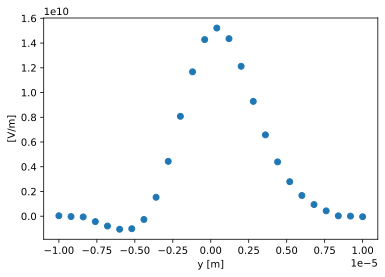

In [10]:
Ex_line.plot()

Alternatively it is possible to work interactively with `plopp`'s tools for visualizing multidimensional data, such as `pp.slicer`or `pp.inspector`.

#### Doing math
Just as an example we can easily plot the square of the field:

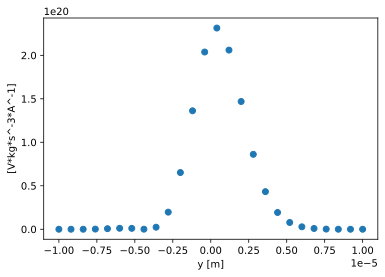

In [11]:
(Ex_line * Ex_line).plot()

### Loading chunks
In the above example the whole 3D field is loaded into memory and sliced afterward. It is also possible to just load a sub-chunk into memory. When the `relay` option in `get_field` is set to `True` it will return a dummy object that only allocates memory for a single value. This relay object can be indexed, sliced etc. using the `scipp` indexing just like before. (The only limitation given by the `openpmd-api` is that the result has to a be contiguous chunk of the original array). The `load_data` method loads data and returns a proper `scipp` data array. 

In [12]:
# The full 3D array is not loaded into memory at this point.
Ex = data_loader.get_field('E', 'x', time=65 * sc.Unit('fs'), relay=True)
# This time we will select a range rather than a slice. For a range there is no need for an exact match.
# But, we could also select a slice just like in the previous example.
Ex = Ex['x', -2e-6 * sc.Unit('m'):2e-6 * sc.Unit('m')]
# Only now the smaller subset wil be loaded into memory
Ex = Ex.load_data()
Ex

Series does not contain iteration at the exact time. Using closest iteration instead.


<scipp.DataArray>
Dimensions: Sizes[x:5, y:26, z:201, ]
Coordinates:
* t                         float64              [s]  ()  6.56942e-14
* x                         float64              [m]  (x)  [-1.6e-06, -8e-07, ..., 8e-07, 1.6e-06]
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (z)  [4.7e-06, 4.8e-06, ..., 2.46e-05, 2.47e-05]
Data:
                            float64            [V/m]  (x, y, z)  [-3.65733e+08, -5.01237e+08, ..., 0, 0]

### Time axis
It is also possible to combine arrays from different iterations into one using `scipp`'s `concat` function. Here is an example for creating a 4D array from all iterations:

In [13]:
Ex = sc.concat([data_loader.get_field('E', 'x', iteration=iteration.value, time_tolerance=None)
                for iteration in data_loader.iterations['iteration_id']], dim='t')
Ex

<scipp.DataArray>
Dimensions: Sizes[t:5, x:26, y:26, z:201, ]
Coordinates:
* t                         float64              [s]  (t)  [3.28471e-14, 6.56942e-14, ..., 1.31388e-13, 1.64236e-13]
* x                         float64              [m]  (x)  [-9.6e-06, -8.8e-06, ..., 9.6e-06, 1.04e-05]
* y                         float64              [m]  (y)  [-1e-05, -9.2e-06, ..., 9.2e-06, 1e-05]
* z                         float64              [m]  (t, z)  [-5.2e-06, -5.1e-06, ..., 5.41e-05, 5.42e-05]
Data:
                            float64            [V/m]  (t, x, y, z)  [-1.08549e+07, -1.3967e+07, ..., 0, 0]

The reason for the z coordinate having two dimensions (t,z) is the fact that the data comes from a moving window simulation. This is clearly visible in the plot below.

In [14]:
# Let us just slice at some points to get a 2D dataset
Ex = Ex['x', 10]['y', 10]
Ex

<scipp.DataArray>
Dimensions: Sizes[t:5, z:201, ]
Coordinates:
* t                         float64              [s]  (t)  [3.28471e-14, 6.56942e-14, ..., 1.31388e-13, 1.64236e-13]
  x                         float64              [m]  ()  -1.6e-06
  y                         float64              [m]  ()  -2e-06
* z                         float64              [m]  (t, z)  [-5.2e-06, -5.1e-06, ..., 5.41e-05, 5.42e-05]
Data:
                            float64            [V/m]  (t, z)  [-8.41738e+08, -7.8752e+08, ..., 0, 0]

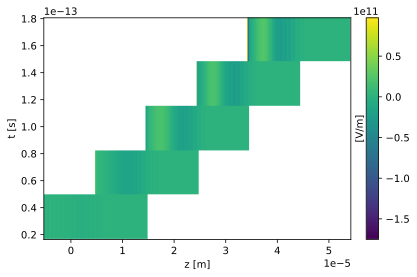

In [15]:
Ex.plot()

### Working with particle data
Coming soon!